In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
from rlway.pyosrd.osrd import OSRD

In [102]:
sim = OSRD(use_case='c2y13s', dir='tmp')

[15:27:35,229] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[15:27:35,262] [INFO]              [FullInfra] parsing infra
[15:27:35,322] [INFO]              [FullInfra] adaptation to kotlin
[15:27:35,357] [INFO]              [FullInfra] loading signals
[15:27:35,362] [INFO]              [FullInfra] building blocks
[15:27:35,367] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[15:27:35,379] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.12
[15:27:35,429] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.13
[15:27:35,440] [INFO]  [StandaloneSimulationCommand] All simulations completed
[15:27:35,440] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json


In [103]:
sim._head_position(0)

def time_train_is_at_point_id(
    self,
    train: int,
    point_id: str,
    eco_or_base:str = 'base',
) -> float:
    """At what time a given train arrives at a given encountered point ?"""
    return [
        point[f't_{eco_or_base}']
        for point in self.points_encountered_by_train(train)
        if point['id'] == point_id
    ][0]

In [104]:
import json
import os

import numpy as np

from rlway.pyosrd import OSRD

def add_delay_in_results(
    self,
    train: int,
    point_id: str,
    delay: float,
    eco_or_base: str = 'base',
) -> None:
    """Adds a delay to simulation results (and json file) for a train after a given point

    Warning: route_occupancies are not updated

    Parameters
    ----------
    self : OSRD
       OSRD simulation object
    train : int
        train index
    point_id : str
        Point id
    delay : float
        Delay in seconds
    eco_or_base : str, optional
        Modify eco or base simulation ?, by default 'base'
    """

    time_threshold = time_train_is_at_point_id(self, train, point_id)

    group, idx = self._train_schedule_group[
        self.trains[train]
    ]

    for eco_or_base in ['eco', 'base']:
        sim = f'{eco_or_base}_simulations'

        dict = (
            self.results[group][sim][idx]
            if self.results[group][sim] != [None]
            else {}
        )
        for key, records in dict.items():
            if isinstance(records, list):
                for i, record in enumerate(records):
                    for subkey, value in record.items():
                        if 'time' in subkey and value > time_threshold:
                            self.results[group][sim][idx][key][i][subkey] += \
                                delay

    with open(os.path.join(self.dir, self.results_json), "w") as outfile:
        json.dump(self.results, outfile)

In [105]:
import json

delays = [
    {
        "train_id": "train0",
        "point_id": "SA0",
        "delay": 300,
    }
]

with open(os.path.join(sim.dir, 'delays.json'), "w") as outfile:
    json.dump(delays, outfile)

In [106]:
sim._train_schedule_group

{'train0': ('group.12', 0), 'train1': ('group.13', 0)}

In [115]:
import json
import os
from copy import deepcopy


delayed = deepcopy(sim)
name = 'delayed'
delays_json = 'delays.json'

delayed.results_json=os.path.join(name, 'results.json')

directory = os.path.join(sim.dir, name)
if not os.path.exists(directory):
    os.mkdir(directory)

with open(os.path.join(sim.dir, 'delays.json'), 'r') as f:
    delays = json.load(f)

for delay in delays:
    delayed.add_delay_in_results(
        train=sim.trains.index(delay['train_id']),
        point_id=delay['point_id'],
        delay=delay['delay'],
    )


regulated = deepcopy(delayed)
regulated.simulation_json='delayed/regulated/simulation.json'
regulated.results_json='delayed/regulated/results.json'

directory = os.path.join(sim.dir, name, 'regulated')
if not os.path.exists(directory):
    os.mkdir(directory)

regulated.add_stop(train=0, position=780, duration=150)
for delay in delays:
    add_delay_in_results(
        regulated,
        train=sim.trains.index(delay['train_id']),
        point_id=delay['point_id'],
        delay=delay['delay'],
    )

[15:29:30,850] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[15:29:30,884] [INFO]              [FullInfra] parsing infra
[15:29:30,947] [INFO]              [FullInfra] adaptation to kotlin
[15:29:30,983] [INFO]              [FullInfra] loading signals
[15:29:30,989] [INFO]              [FullInfra] building blocks
[15:29:30,994] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/delayed/regulated/simulation.json
[15:29:31,006] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.12
[15:29:31,061] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.13
[15:29:31,075] [INFO]  [StandaloneSimulationCommand] All simulations completed
[15:29:31,075] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/delayed/regulated/results.json


In [116]:
import matplotlib.pyplot as plt
points_to_show = ['switch', 'signal', 'departure', 'switch', 'arrival', 'station']
fig1 = sim.space_time_chart_plotly(0, points_to_show=points_to_show)
fig2 = delayed.space_time_chart_plotly(0, points_to_show=points_to_show)
fig3 = regulated.space_time_chart_plotly(0, points_to_show=points_to_show)

In [117]:
fig1.show()
fig2.show()
fig3.show()

In [118]:
from rlway.schedules import schedule_from_osrd

s = schedule_from_osrd(sim)
sd = schedule_from_osrd(delayed)
sr = schedule_from_osrd(regulated)

<Axes: xlabel='Time'>

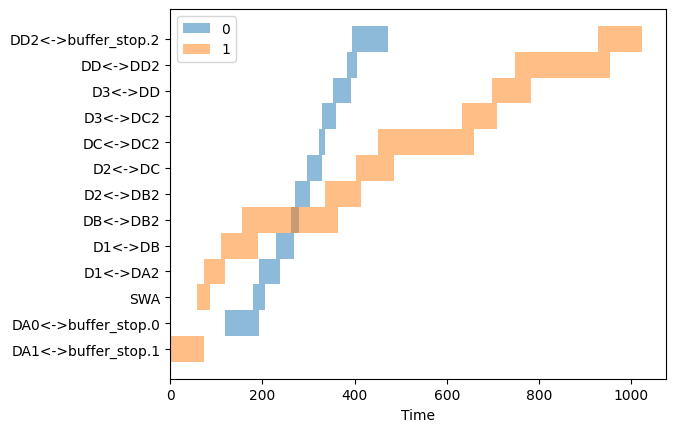

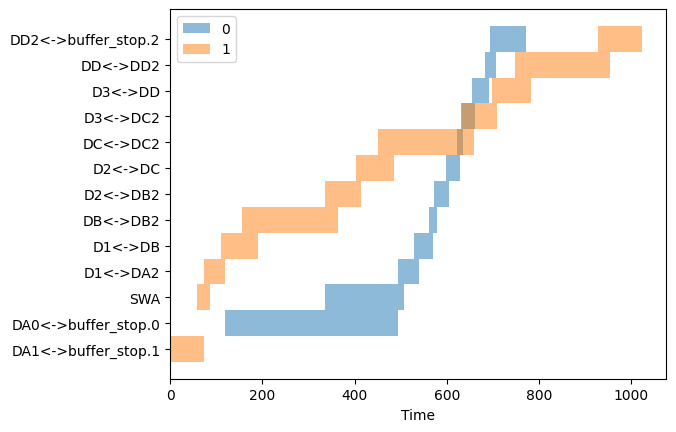

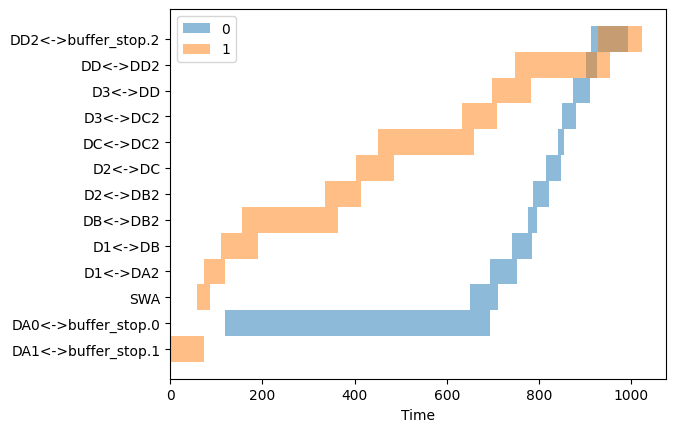

In [122]:
s.sort().plot()
sd.sort().plot()
sr.sort().plot()